
# **Lista 06 Processamento Digital de Imagens**
Professora: Mylene Farias

Monitores: André da Costa e Lucas Althoff

---

In [ ]:
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy import fftpack
from scipy.stats   import entropy
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim

arraste ou faça o upload das imagens em anexo para o diretório "Files" ao lado, **fora das pastas**. 

#Problema 1

> **1.1**  Escolha uma imagem de no mínimo 512x512. Leia e visualize a imagem.


> **1.2** Aplique a transformada DCT-2D em a cada um dos blocos 8 × 8 da imagem. Normalize o resultado, dividindo todos os elementos da matriz resultante por 8. Visualize o seu resultado.

> **1.3** O valor do parâmetro *qualidade* ($\small 1 \leq \text{qual}\leq 100 $) controla a escala de quantização na compressão:

$$ \small
\text{escala}_{q} = 
\begin{cases}
    \frac{50}{\text{qual}},& \text{if } \text{qual} \geq 50\\
    2 - \frac{\text{qual}\cdot 2}{100},              & \text{otherwise}.
\end{cases}
$$

> A matriz de quantização é dada por:

$$ \small
            Q = \left[ \begin{array}{llllllll}
                 16&11&10&16&24&40&51&61\\
                 12&12&14&19&26&58&60&55\\
                 14&13&16&24&40&57&69&56\\
                 14&17&22&29&51&87&80&62\\
                18&22&37&56&68&109&103&77\\
                24&35&55&64&81&104&113&92\\
                49&64&78&87&103&121&120&101\\
                72&92&95&98&112&100&103&99
              \end{array} \right].
$$

A matriz de quantizacão modificada para o nível de qualidade desejado pode ser obtida utilizando a seguinte função:

$$\small
 \text{Quant}_T = \max\left(ones(size(Q), \text{round}(\text{escala}_q \cdot Q))\right)
 $$

Escolha um nível de qualidade igual a 50. Divida os elemento de cada um dos blocos 8x8 de coeficientes DCT normalizados pelo elemento correspondente da matriz de quantização, arredondando o resultado para o próximo inteiro. Observe que $\small \text{Quant}_T$ tem 8 linhas e 8 colunas, assim como os blocos de coeficientes DCT. Você acabou de executar um JPEG simplificado.

**1.4** Calcule a entropia da imagem original e da imagem obtida no passo anterior. Qual o resultado? O que você pode concluir deste resultado?

**1.5** Para recuperar a imagem, multiplique cada elemento dos blocos obtidos no item anterior pelo mesmo elemento $\text{Quant}_T$. Em seguida, calcule a IDCT dos blocos 8x8 resultantes e multiplique o seu resultado por 8, obtendo a imagem resultante. Visualize a imagem resultante.

**1.6** Métricas de qualidade podem ser utilizadas para obter o nível de degradação de uma imagem, quando comparada a um original. Mean square error (erro médio quadrático) é um métrica bem simplest da seguinte forma:
$$ \small
MSE = \sum_i^L \sum_j^C{\frac{(I(i,j) - I_r(i,j))^2}{L \cdot C}}
$$
na qual $I_r$ é a imagem resultante $I$ a original (I). Já o peak signal to noise ratio (PSNR), uma métrica bastante popular, pode ser obtido a partir do MSE, utilizando a seuinte equação:
$$ \small
PSNR = 10 \log_{10} \frac{(255)^2}{MSE}.
$$
Finalmente, uma outra métrica popular é a structural similarity index metric (ssim). Calcule o valor do PSNR e do SSIM entre a imagem original e reconstruída. 

> Exemplo do uso das métricas: https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html

**1.7** Repita os itens para:
- 3 outras imagens de conteúdo bem diferentes;
- 10 níveis de qualidade (qual) entre 55 e 100.

Para cada caso, calcule o PSNR e o SSIM  para cada métrica por imagem. De posse destes dados, obtenha para cada imagem um gráfico de PSNR e um gráfico de SSIM, no qual o eixo x corresponde o valor qualidade (qual) e o eixo y possui o valor obtido com a métrica. 

Os resultados de MSE ainda são consistentes? É possível comparar os resultados de PSNR entre as imagens? E os do SSIM? 



1.1

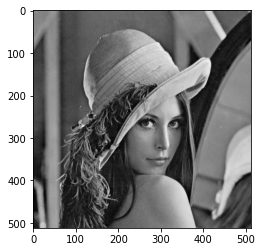

In [ ]:
def grayscale(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width = img.shape
  #print('Altura       : ',height)
  #print('Largura      : ',width)
  plt.figure()
  plt.imshow(img, 'gray') 
  plt.show() 
  return img


img = grayscale('lenna.png')

1.2


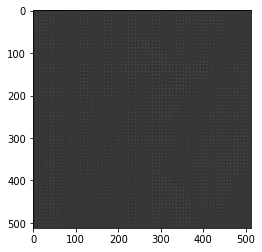

In [ ]:
def dct2D(img, n):
    altura, largura = img.shape    
    img_out = np.zeros((altura, largura), dtype=np.float32)
    for i in range(0, altura, 8):
        for j in range(0, largura, 8):
            img_out[i:i+n, j:j+n] = fftpack.dct(fftpack.dct(img[i:i+n, j:j+n].T, norm='ortho').T, norm='ortho')
    img_out = img_out/8
    return img_out

img_dct_2D = dct2D(img, 15)
plt.figure()
plt.imshow(img_dct_2D, 'gray') 
plt.show() 

1.3

Altura       :  512
Largura      :  512


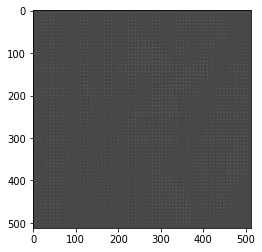

In [ ]:
def jpeg(img, qual, N, op):
  Q = np.array([[16, 11, 10, 16,  24,  40,  51,  61],
                  [12, 12, 14, 19,  26,  58,  60,  55],
                  [14, 13, 16, 24,  40,  57,  69,  56],
                  [14, 17, 22, 29,  51,  87,  80,  62],
                  [18, 22, 37, 56,  68, 109, 103,  77],
                  [24, 35, 55, 64,  81, 104, 113,  92],
                  [49, 64, 78, 87, 103, 121, 120, 101],
                  [72, 92, 95, 98, 112, 100, 103,  99]]) 
  altura, largura = img.shape
  Q_altura, Q_largura = Q.shape
  if qual <= 50:
    qualidade = 50.0/qual
  else:
    qualidade = (2 - ((qual*2)/100))
  Q_ones = np.ones((Q_altura, Q_largura))
  Q_quant = qualidade*Q
  quant_T = np.maximum(Q_ones, Q_quant)
  img_out = np.zeros((altura, largura), dtype=float)
  for i in range(int(altura/N)):
      for j in range(int(largura/N)):
        if op == 1:
          img_out[i*N:(i+1)*N, j*N:(j+1)*N] = img[i*N:(i+1)*N, j*N:(j+1)*N]/quant_T
        if op == 2: #recover
          img_out[i*N:(i+1)*N, j*N:(j+1)*N] = img[i*N:(i+1)*N, j*N:(j+1)*N]*quant_T
  return img_out

img_path = 'lenna.png'
img_jpeg = jpeg(img_dct_2D,50,8,1)  
cv2.imwrite('./lenna.jpeg', img_jpeg)
print('Altura       : ',img_jpeg.shape[0])
print('Largura      : ',img_jpeg.shape[1])
plt.figure()
plt.imshow(img_jpeg, 'gray') 
plt.show() 

1.4

In [ ]:
def idct2D(img, n):
    altura, largura = img.shape    
    img_out = np.zeros((altura, largura), dtype=np.float32)
    for i in range(0, altura, 8):
        for j in range(0, largura, 8):
            img_out[i:i+n, j:j+n] = fftpack.idct(fftpack.idct(img[i:i+n, j:j+n].T, norm='ortho').T, norm='ortho')
    img_out = img_out/8
    return img_out

recovered = jpeg(img_jpeg, 50, 8,2)
recovered = idct2D(recovered*8, 8)

1.5

In [ ]:
print("A entropia da imagem original é: ", entropy(entropy(img)))
print("A entropia da imagem reconvertida é: ",entropy(entropy(recovered)))

A entropia da imagem original é:  6.238310196347633
A entropia da imagem reconvertida é:  6.2383103


O resultado é esperado. A entropia da imagem original e a reconvertida no domínio do tempo pela IDCT são parecidas mas com diferentes casas decimais, devido ao erro da conversão da imagem comprimida para a imagem no domínio do tempo.


1.6

In [ ]:
def calculate_psnr(img1, img2):
    import math   
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))
print("PSNR: ", calculate_psnr(img, recovered))
print("SSIM: ",ssim(img, recovered,  data_range=img.max() - recovered.min()))

PSNR:  8.819055935626109
SSIM:  0.23401352776472287


1.7

In [ ]:
lista = ['arvore.jpg', 'flor.jpg', 'barbara.png']
valores = [55,60,65,70,75,80,85,90,95,100]
for path in lista:
  for n in valores:
    img = grayscale(path)
    img_dct_2D = dct2D(img, 15)
    img_jpeg = jpeg(img_dct_2D,n,8,1)
    recovered = jpeg(img_jpeg, 50, 8,2)
    recovered = idct2D(recovered*8, 8)  
    print("-------- Valor de qualidade: ", n, "---------------- \n")
    print("A entropia da imagem original é: ", entropy(entropy(img)))
    print("A entropia da imagem reconvertida é: ",entropy(entropy(recovered)))
    print("PSNR: ", calculate_psnr(img, recovered))
    print("SSIM: ",ssim(img, recovered,  data_range=img.max() - recovered.min()))   

 

#Problema 2

**2.1** Implemente o algorithmo Lempel-Ziv. O seu algoritmo deve ter como entrada uma imagem (uint8) e como saída a imagem codificada.  

**2.2** Utilizando o algoritmo implementado, comprima as três imagens utilizadas no problema anterior. 

**2.3** Obtenha:
- a entropia de cada uma das três imagens;
- Calcule a razão de compressão para as três imagens codificadas. 

**2.4** Para cada uma das 3 imagens, calcule a imagem diferença, ou seja $\small Id(i,j) = I(i,j) - I(i,j+1)$. Em seguida, calcule a entropia destas imagens diferença. O que pode ser observado? 

**2.5** Utilize o código Lempel-Ziv para comprimir cada uma das imagens diferenças. Calcule novamente a razão de compressão. O que aconeceu? Como você explica estes resultados? 

2.1


Save the LZW.py file
Use from LZW import LZW
For compression:
compressor = LZW('''Path to Image''')
compressor.compress()
For decompression:
decompressor = LZW('''Path to LZW File''')
decompressor.decompress()


In [ ]:
!git clone https://github.com/ashmeet13/LZW-Image-Compression


fatal: destination path 'LZW-Image-Compression' already exists and is not an empty directory.


2.2

In [ ]:
!python /content/LZW-Image-Compression/main.py

Traceback (most recent call last):
  File "/content/LZW-Image-Compression/main.py", line 1, in <module>
    from LZW import LZW
ModuleNotFoundError: No module named 'LZW'


In [ ]:
%cd /content/LZW-Image-Compression

/content/LZW-Image-Compression


In [ ]:
!python /content/LZW-Image-Compression/main.py

Compressing Image ...
Compressing Image ...
Compressing Image ...
Image Compressed --------- Writing to File
Decompressing File ...
Saving Decompressed File...
Decompression Done.


In [ ]:
lista = ['arvore.jpg', 'flor.jpg', 'lenna.png']
for path in lista: 
  compressor = LZW(path)
  compressor.compress()

#decompressor

decompressor1 = LZW('/content/LZW-Image-Compression/CompressedFiles/lennaCompressed.lzw')
decompressor1.decompress()
decompressor2 = LZW('/content/LZW-Image-Compression/CompressedFiles/florCompressed.lzw')
decompressor2.decompress()
decompressor3 = LZW('/content/LZW-Image-Compression/CompressedFiles/arvoreCompressed.lzw')
decompressor3.decompress()



Compressing Image ...
Compressing Image ...
Compressing Image ...
Image Compressed --------- Writing to File
Compressing Image ...
Compressing Image ...
Compressing Image ...
Image Compressed --------- Writing to File
Compressing Image ...
Compressing Image ...
Compressing Image ...
Image Compressed --------- Writing to File
Decompressing File ...
Saving Decompressed File...
Decompression Done.
Decompressing File ...
Saving Decompressed File...
Decompression Done.
Decompressing File ...
Saving Decompressed File...
Decompression Done.


2.3

In [39]:
img1 = cv2.cvtColor(cv2.imread('/content/LZW-Image-Compression/DecompressedFiles/lennaDecompressed.tif'), cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(cv2.imread('/content/LZW-Image-Compression/DecompressedFiles/arvoreDecompressed.tif'), cv2.COLOR_BGR2GRAY)
img3 = cv2.cvtColor(cv2.imread('/content/LZW-Image-Compression/DecompressedFiles/florDecompressed.tif'), cv2.COLOR_BGR2GRAY)
print("A entropia da imagem 1 é: ", entropy(img1))
print("A entropia da imagem 2 é: ",entropy(entropy(img2)))
print("A entropia da imagem 3 é: ", entropy(entropy(img3)))

A entropia da imagem 1 é:  [6.14794996 6.14794996 6.1527508  6.15334402 6.15513369 6.1587588
 6.16188084 6.1700201  6.17388294 6.17537016 6.17718328 6.17740014
 6.17615513 6.17100372 6.16832196 6.16002956 6.15403786 6.14742626
 6.1495999  6.15032892 6.15198604 6.15388196 6.15627104 6.16131511
 6.1639205  6.16427735 6.1671236  6.17540375 6.18628035 6.19559297
 6.20549297 6.21643289 6.22402457 6.23010366 6.23271511 6.23525489
 6.23635141 6.23725329 6.23764826 6.23777169 6.23769356 6.23761457
 6.23759798 6.23749071 6.2375464  6.23743886 6.23741763 6.2372657
 6.23727511 6.23713904 6.23716306 6.23692885 6.23646189 6.23596577
 6.23532776 6.23495234 6.23427189 6.23390964 6.23358312 6.23277742
 6.23172122 6.22981529 6.22905327 6.21931679 6.20278971 6.19337064
 6.19582369 6.19649292 6.20447982 6.20805419 6.20492837 6.20685263
 6.20041299 6.20097122 6.19260466 6.19793633 6.20079216 6.19938541
 6.19696476 6.19807281 6.19625743 6.19572401 6.19764461 6.19604718
 6.1939253  6.19584397 6.19984665 6.2

2.4

2.5